# Predicting the extent of regional drought $n$ weeks in advance

The full repository, including data and source code, can be found [here](https://github.com/JLRipley314/US-Drought-Data).

The USDM keeps statistics on the percentage of drought in different major climatic regions of the contiguous United States. 
This is a large enough area that the drought data doesn't just immediately jump from zero to 100%. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We consider comprehensive statistics -- that is the percentage (of land area) that each climate region is in the D0-D4 drought categories.

## Overview of the data 

In [2]:
dm_data= pd.read_csv("../Data/climate_region_comprehensive_D0_through_D4.csv")
dm_data

,MapDate,Region,None,D0,D1,D2,D3,D4,ValidStart,ValidEnd,StatisticFormatID
0,20231010,High Plains,57.12,42.88,27.48,15.26,5.44,0.97,2023-10-10,2023-10-16,1
1,20231010,Midwest,16.15,83.85,55.51,21.95,6.14,0.35,2023-10-10,2023-10-16,1
2,20231010,Northeast,83.24,16.76,2.47,0.27,0.00,0.00,2023-10-10,2023-10-16,1
3,20231010,South,15.63,84.37,66.02,48.72,27.77,11.61,2023-10-10,2023-10-16,1
4,20231010,Southeast,40.27,59.73,27.26,8.68,1.26,0.00,2023-10-10,2023-10-16,1
...,...,...,...,...,...,...,...,...,...,...,...
7441,20000104,Midwest,26.35,73.65,41.30,7.29,0.00,0.00,2000-01-04,2000-01-10,1
7442,20000104,Northeast,92.83,7.17,2.58,0.00,0.00,0.00,2000-01-04,2000-01-10,1
7443,20000104,South,14.90,85.10,57.90,30.74,0.00,0.00,2000-01-04,2000-01-10,1
7444,20000104,Southeast,28.58,71.42,42.59,19.20,0.00,0.00,2000-01-04,2000-01-10,1


In [3]:
regions = set(dm_data["Region"])
regions

{'High Plains', 'Midwest', 'Northeast', 'South', 'Southeast', 'West'}

### Visualization of drought data from different counties

Before training our model, we look at what this data looks like from different climate regions in the U.S. 

In [4]:
def get_region(region_name):
    return dm_data.loc[dm_data["Region"] == region_name][::-1] # make in chronological order

In [5]:
def plot_region(region_name):
    region = get_region(region_name)

    fig, axs = plt.subplots(1,1,sharex=True,sharey=True,figsize=(15,5))
    axs.fill_between(x=region["ValidEnd"],y1=0,y2=region["D0"],color="k",alpha=0.1,label="D0")
    axs.fill_between(x=region["ValidEnd"],y1=0,y2=region["D1"],color="k",alpha=0.3,label="D1")
    axs.fill_between(x=region["ValidEnd"],y1=0,y2=region["D2"],color="k",alpha=0.5,label="D2")
    axs.fill_between(x=region["ValidEnd"],y1=0,y2=region["D3"],color="k",alpha=0.7,label="D3")
    axs.fill_between(x=region["ValidEnd"],y1=0,y2=region["D4"],color="k",alpha=0.9,label="D4")
    axs.set_xticks(axs.get_xticks()[::156])
    axs.set_xlabel("Date") 
    axs.set_ylabel("Percentage in drought")
    axs.legend()
    fig.suptitle(region_name)
    plt.tight_layout()

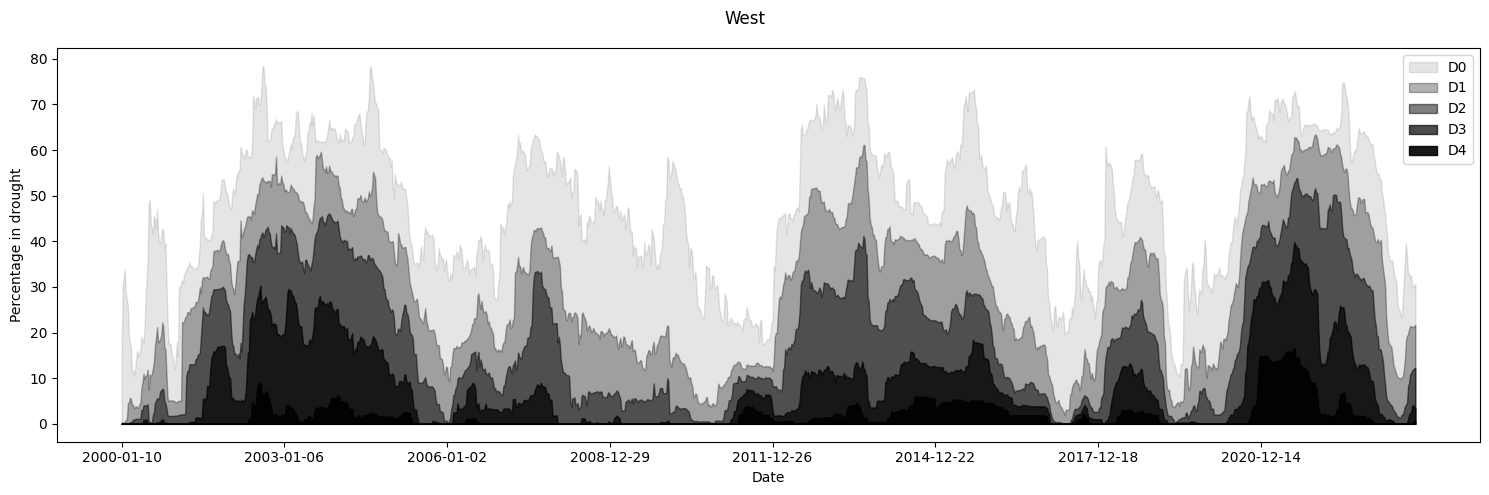

In [6]:
plot_region("West")

### Summary statistics

Our main takeaway from this qualitative analysis is that drought appears to have been much more extensive and severe in the West/High Plains of the U.S., while drought has been least common in the northeast. 
We can see this a different way by considering the mean and standard deviations of the different drought levels.

In [7]:
for region in regions:
    print(f"Mean drought of {region}:")
    print(f"\t D0: {np.mean(get_region(region)['D0']):.4f} +/- {np.std(get_region(region)['D0']):.2f}")
    print(f"\t D1: {np.mean(get_region(region)['D1']):.4f} +/- {np.std(get_region(region)['D1']):.2f}")
    print(f"\t D2: {np.mean(get_region(region)['D2']):.4f} +/- {np.std(get_region(region)['D2']):.2f}")
    print(f"\t D3: {np.mean(get_region(region)['D3']):.4f} +/- {np.std(get_region(region)['D3']):.2f}")
    print(f"\t D4: {np.mean(get_region(region)['D4']):.4f} +/- {np.std(get_region(region)['D4']):.2f}")

Mean drought of High Plains:
	 D0: 54.4743 +/- 26.79
	 D1: 34.3974 +/- 26.74
	 D2: 20.2624 +/- 21.57
	 D3: 8.9396 +/- 13.60
	 D4: 1.8907 +/- 4.80
Mean drought of Northeast:
	 D0: 21.0219 +/- 22.17
	 D1: 6.6900 +/- 12.76
	 D2: 1.8622 +/- 6.12
	 D3: 0.3138 +/- 1.64
	 D4: 0.0042 +/- 0.10
Mean drought of Midwest:
	 D0: 29.4902 +/- 21.20
	 D1: 13.6443 +/- 15.12
	 D2: 4.8602 +/- 7.85
	 D3: 1.2314 +/- 3.33
	 D4: 0.0552 +/- 0.46
Mean drought of South:
	 D0: 47.2636 +/- 25.78
	 D1: 30.5705 +/- 23.22
	 D2: 17.8956 +/- 18.12
	 D3: 8.5366 +/- 12.27
	 D4: 2.8582 +/- 7.33
Mean drought of West:
	 D0: 47.8946 +/- 15.61
	 D1: 30.6061 +/- 16.51
	 D2: 18.9620 +/- 14.58
	 D3: 8.4200 +/- 9.15
	 D4: 1.8778 +/- 3.11
Mean drought of Southeast:
	 D0: 39.2310 +/- 29.43
	 D1: 21.4408 +/- 23.92
	 D2: 11.2094 +/- 16.72
	 D3: 5.0416 +/- 9.92
	 D4: 1.4285 +/- 4.48


#### How Gaussian is the data? 
We consider histograms of the data and QQ plots.

In [8]:
def normal(x, mu, sig):
    return 1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2)

def plot_region_hist(region_name):
    """
    Compare data (normalized to have zero mean and unit variance)
    to a Gaussian with zero mean and unit variance.
    """
    region = get_region(region_name)

    fig, axs = plt.subplots(1,5,sharex=False,sharey=True,figsize=(15,5))
    for i in range(5):
        D = region[f"D{i}"]
        D -= np.mean(D)
        D /= np.std(D)
        axs[i].hist(D,density=True,color="k")
        axs[i].set_title(f"D{i}")
        xv = np.linspace(np.min(D),np.max(D))
        yv = normal(xv, np.mean(xv), np.std(xv))
        axs[i].plot(xv,yv,linewidth=4,color="y")
    axs[0].set_ylabel("Relative amount of time")
    fig.legend(labels=["N(0,1)","histogram"], ncol=2)
    fig.suptitle(region_name)
    plt.tight_layout()

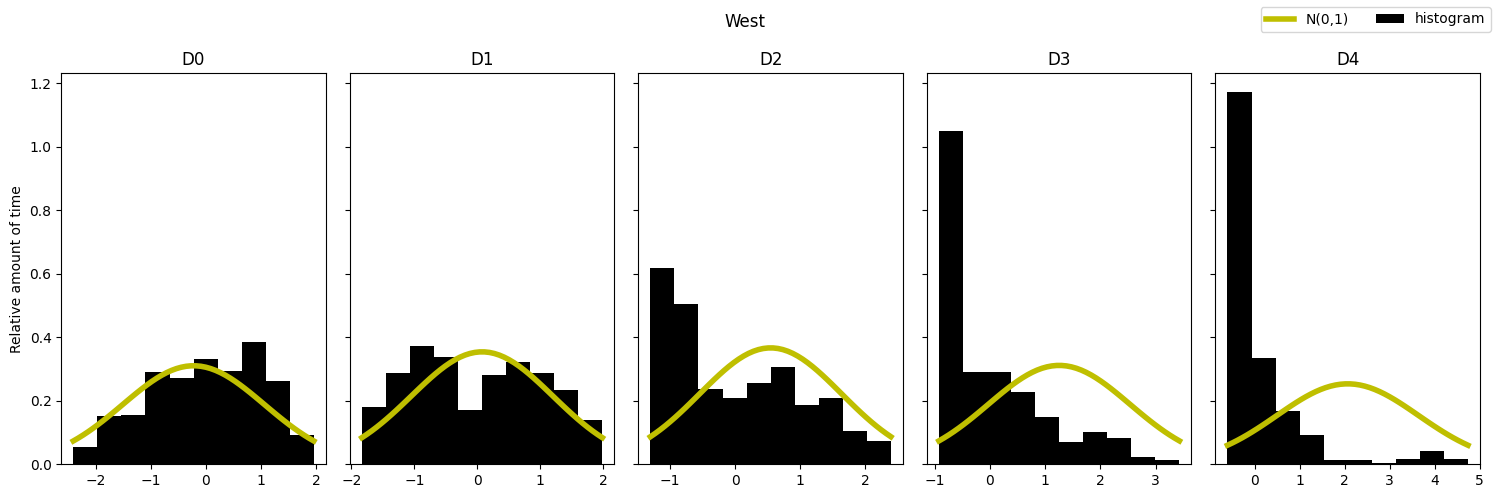

In [9]:
plot_region_hist("West")

We see that the D0 region drought percentages look approximately normally distributed, but not the higher drought values, which are piled up near x percent.
We can see this a different way by looking at QQ-plots.

In [10]:
import statsmodels
from statsmodels.graphics.gofplots import qqplot

def plot_region_qq(region_name):
    """
    Compare data (set to zero mean and unit variance) to Normal distribution in a QQ plot.
    """
    region = get_region(region_name)

    fig, axs = plt.subplots(1,5,sharex=False,sharey=True,figsize=(15,5))
    for i in range(5):
        D = region[f"D{i}"]
        D -= np.mean(D)
        D /= np.std(D)
        qqplot(D,ax=axs[i])
        axs[i].set_title(f"D{i}")
    fig.suptitle(region_name)
    plt.tight_layout()

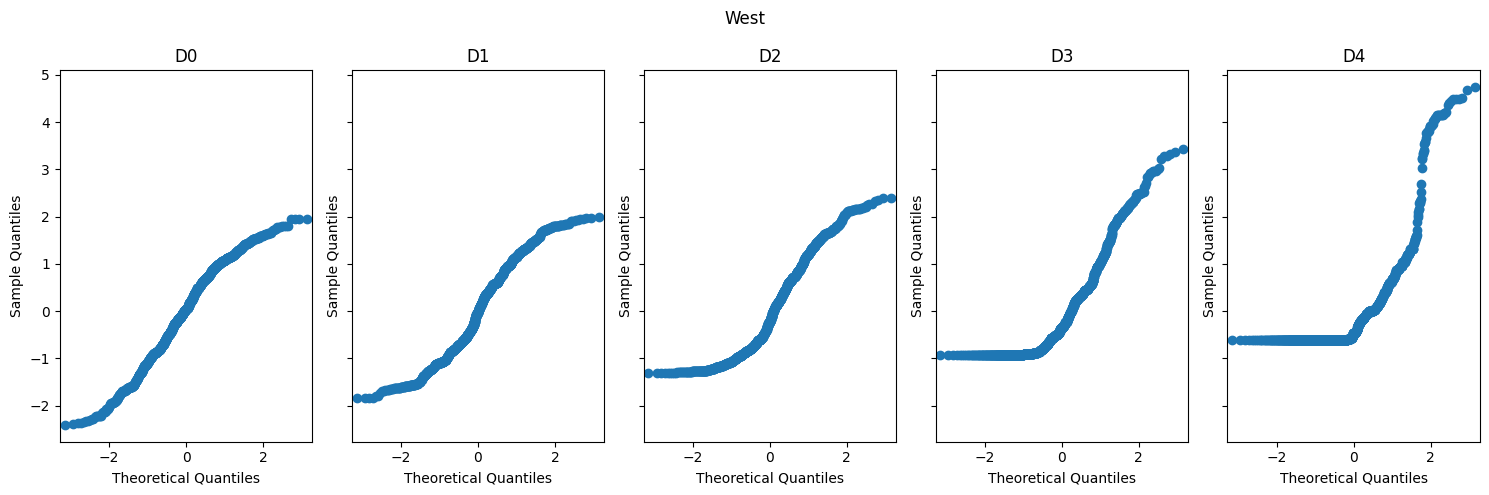

In [11]:
plot_region_qq("West")

#### What beta distribution best fits the data?

We consider a beta distribution, 
\begin{align}
    B\left(x,a,b\right)
    \equiv
    \frac{\Gamma\left(a+b\right)}{\Gamma\left(a\right)\Gamma\left(b\right)}
    x^{a-1}\left(1-x\right)^{b-1}
    ,
\end{align}
and minimize it with respect the parameters $a,b$, as compared to the data.
We minimize the pointwise Kullback-Leibler divergence, defined in [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.kl_div.html) to be

\begin{align}
    KL\left(x,y\right)
    \equiv&
    \sum_i 
    KL_i\left(x_i,y_i\right)
    ,\\
    KL_i\left(x_i,y_i\right)
    \equiv&
    \begin{cases}
        x \ln\left(\frac{x}{y}\right) - x + y & x>0 \; y>0
        \\
        y & x=0 \; y>0 
        \\
        \infty & \mathrm{otherwise}
    \end{cases}
    \; ,
\end{align}
where the sum is taken over all points of two arrays.

That is, we normalize the drought data in each category so that the drought index histogram $h(x)$ lies between $x\in[-1,1]$, and is normalized. We then compare $KL\left(h(x),B\left(x,a,b\right)\right)$, and minimize that function with respect to $a$ and $b$.

We consider a beta distribution as it is a fairly flexible distribution, and staring at the drought histograms, it looks like a beta distribution could fit the different category histograms fairly well.

In [12]:
import scipy

In [13]:
def B(x,a,b):
    """
    Beta probability distribution function.
    """
    return (1/scipy.special.beta(a,b)) * pow(x,a-1) * pow(1-x,b-1)

def get_closest_beta(region_name, bins=20):
    """
    Find closest fitting beta distribution
    """
    region = get_region(region_name)

    ab = np.array([[0,0] for i in range(5)])
    
    for i in range(5):
        D = region[f"D{i}"]
        D -= np.min(D)
        D /= np.max(abs(D))

        dens, edges = np.histogram(D, bins=bins, density=True)
        points = np.array([(edges[i+1]+edges[i])/2 for i in range(len(dens))])
        
        def f(params):
            if params[0]<1e-2 or params[1]<1e-2:
                return 1e10
            val = np.sum(scipy.special.kl_div(dens,B(points,params[0],params[1])))
            if np.isnan(val):
                return 1e10
            else:
                return val

        a0b0 = np.array([3.0,3.0])

        afbf = scipy.optimize.minimize(f, a0b0)

        ab[i][0] = afbf.x[0]
        ab[i][1] = afbf.x[1]
    return ab

In [14]:
ab = get_closest_beta("West")

In [15]:
def plot_region_hist_beta(region_name,ab,bins=20):
    """
    Compare data (normalized to have zero mean and unit variance)
    to a Gaussian with zero mean and unit variance.
    """
    region = get_region(region_name)

    fig, axs = plt.subplots(1,5,sharex=False,sharey=True,figsize=(15,5))
    for i in range(5):
        D = region[f"D{i}"]
        D -= np.min(D)
        D /= np.max(abs(D))
        axs[i].hist(D,bins=bins,density=True,color="k")
        xv = np.linspace(np.min(D)+1e-4,np.max(D)-1e-4)
        yv = B(xv,max(1e-3,ab[i][0]),max(1e-3,ab[i][1]))
        axs[i].plot(xv,yv,linewidth=4,color="y")
        axs[i].set_title(f"D{i}, a={ab[i][0]}, b={ab[i][1]}")
    axs[0].set_ylabel("Relative amount of time")
    fig.legend(labels=["B(a,b)","histogram"], ncol=2)
    fig.suptitle(region_name)
    plt.tight_layout()

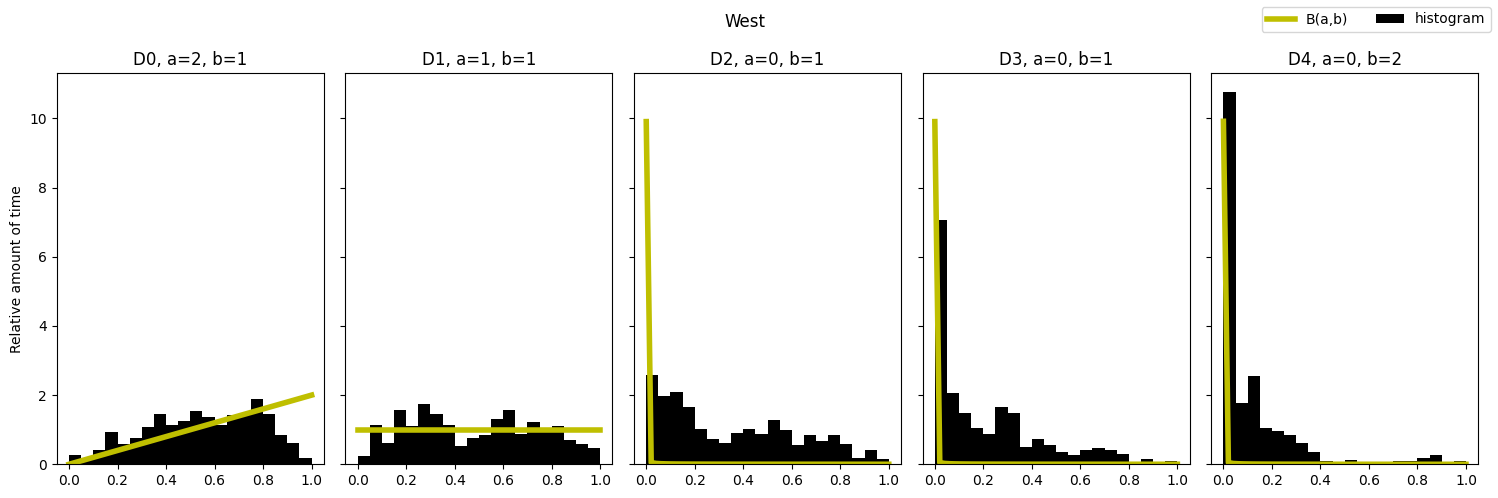

In [16]:
plot_region_hist_beta("West",ab)

In retrospect, the beta distribution does not fit this data very well.

# Training various prediction models on drought data

We would like to give some function a timestream of data that lists the percentage of D0-D4 for a county, and for that function to predict for us the percentages of D0-D4 one week from now. 
We consider several time series prediction models, culminating in an LSTM recurrent neural network.

We roughly follow [this tutorial](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/) and [this tutorial](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/) to set up our LSTM recurrent neural network.

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

## Making the train and test datasets

We rescale the data so that it has zero mean and unit variance.
We then make a sliding window of the data.

In [18]:
def get_region_train_test(region_name, category, train_size):
    """
    Get the regional data, normalize to have zero mean and maximum absolute value of 1.
    """
    region = get_region(region_name)

    timeseries = np.array(region[[category]])

    mean = np.mean(timeseries)
    maxm = np.max(abs(timeseries))
    
    timeseries -= mean
    timeseries /= maxm
    
    train = timeseries[:train_size]
    test  = timeseries[train_size:]

    return timeseries, np.array([mean,maxm]), train, test

In [19]:
def create_windowed_dataset(dataset, window_size):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        window_size: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-window_size):
        feature = dataset[i:i+window_size]
        target = dataset[i+1:i+window_size+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).type(torch.float32), torch.tensor(y).type(torch.float32)

In [20]:
region_name = "West"
category = "D1"

window_size= 8 # 8 weeks = 2 months of window_size
train_size = 1000
timeseries, mean_std, train_set, test_set = get_region_train_test(region, category, train_size)

X_train, y_train = create_windowed_dataset(train_set, window_size=window_size)
X_test, y_test   = create_windowed_dataset(test_set,  window_size=window_size)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([992, 8, 1]) torch.Size([992, 8, 1])
torch.Size([233, 8, 1]) torch.Size([233, 8, 1])


/tmp/ipykernel_23674/2615600964.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.tensor(X).type(torch.float32), torch.tensor(y).type(torch.float32)


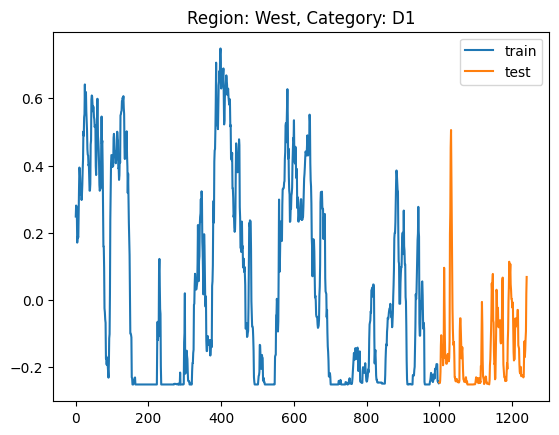

In [21]:
plt.plot(range(train_size),train_set,label="train")
plt.plot(range(train_size,train_size+len(test_set)),test_set,label="test")
plt.title(f"Region: {region_name}, Category: {category}")
plt.legend()

## Persistence model forecast

We first consider forecasting data using a persistence model forecast model.
This model predicts the amount of drought one week from now by simply taking the value of drought one week in the past.
This is a very crude model, but it is very fast and requires no training or hyperparameter tuning.

In [22]:
def persistence_model(data,steps):
    return np.array([x for x in data[:-steps]])

In [23]:
predictions_1 = persistence_model(timeseries,1)
predictions_2 = persistence_model(timeseries,2)
predictions_4 = persistence_model(timeseries,4)

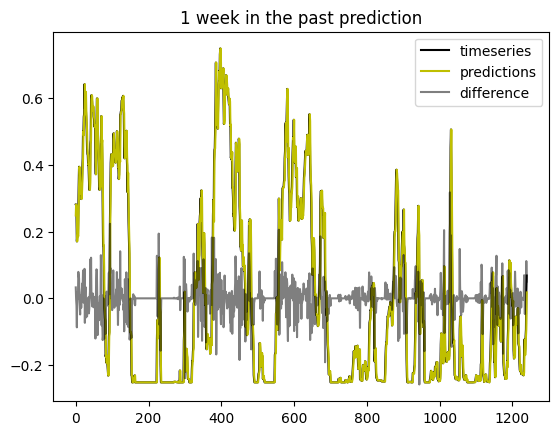

In [24]:
plt.plot(timeseries[1:],              color="k",alpha=1.0,label="timeseries")
plt.plot(predictions_1,               color="y",alpha=1.0,label="predictions")
plt.plot(timeseries[1:]-predictions_1,color="k",alpha=0.5,label="difference")
plt.title("1 week in the past prediction")
plt.legend()

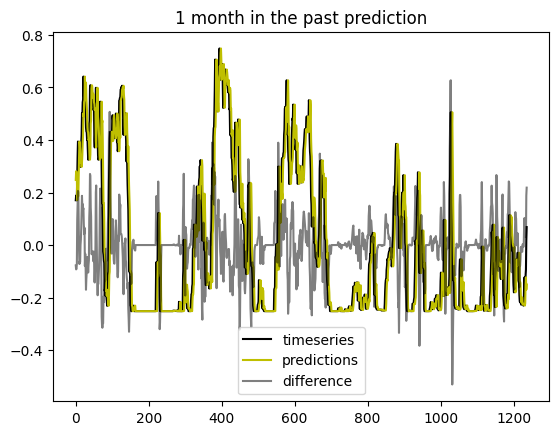

In [25]:
plt.plot(timeseries[4:],              color="k",alpha=1.0,label="timeseries")
plt.plot(predictions_4,               color="y",alpha=1.0,label="predictions")
plt.plot(timeseries[4:]-predictions_4,color="k",alpha=0.5,label="difference")
plt.title("1 month in the past prediction")
plt.legend()

We see that a persistence model does extremely well at predicting future drought.
That is, using the extent of drought last week (or even last month) is a fairly good indicator of the extent of drought this week.
We can see this more quantitively by looking at the root mean squared error of the prediction functions as compared to the timestream.

\begin{align}
    RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^N\left(y^{(pred)}_i - y^{(data)}_i\right)^2}
    .
\end{align}

In [26]:
loss_fn = nn.MSELoss()
rmse_persistence_1 = np.sqrt(loss_fn(torch.tensor(timeseries[1:]),torch.tensor(predictions_1)))
rmse_persistence_2 = np.sqrt(loss_fn(torch.tensor(timeseries[2:]),torch.tensor(predictions_2)))
rmse_persistence_4 = np.sqrt(loss_fn(torch.tensor(timeseries[4:]),torch.tensor(predictions_4)))
print(rmse_persistence_1)
print(rmse_persistence_2)
print(rmse_persistence_4)

tensor(0.0471, dtype=torch.float64)
tensor(0.0741, dtype=torch.float64)
tensor(0.1139, dtype=torch.float64)


## LSTM network

In [27]:
class DroughtModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = DroughtModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

## Training the network: before and after

We consider the network weights before and after training.

In [28]:
weight_ih_before = np.copy(model.lstm.weight_ih_l0.flatten().detach().numpy())
weight_hh_before = np.copy(model.lstm.weight_hh_l0.flatten().detach().numpy())
bias_ih_before = np.copy(model.lstm.bias_hh_l0.flatten().detach().numpy())
bias_hh_before = np.copy(model.lstm.bias_hh_l0.flatten().detach().numpy())
weight_linear_before = np.copy(model.linear.weight.flatten().detach().numpy())

We keep iterating on the weights until the root mean squared error increases for two epochs in a row.

In [29]:
prev_test_rmse = 10
prev_prev_test_rmse = 10
test_rmse = 10
for epoch in range(10000):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 50 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print(f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}")
    if (test_rmse>prev_test_rmse) and (prev_test_rmse>prev_prev_test_rmse):
        break
    prev_prev_test_rmse = prev_test_rmse
    prev_test_rmse = test_rmse

Epoch 0: train RMSE 0.1354, test RMSE 0.1170
Epoch 50: train RMSE 0.0453, test RMSE 0.0486
Epoch 100: train RMSE 0.0453, test RMSE 0.0488
Epoch 150: train RMSE 0.0451, test RMSE 0.0488
Epoch 200: train RMSE 0.0451, test RMSE 0.0483
Epoch 250: train RMSE 0.0445, test RMSE 0.0492
Epoch 300: train RMSE 0.0439, test RMSE 0.0495


In [30]:
weight_ih_after = np.copy(model.lstm.weight_ih_l0.flatten().detach().numpy())
weight_hh_after = np.copy(model.lstm.weight_hh_l0.flatten().detach().numpy())
bias_ih_after = np.copy(model.lstm.bias_hh_l0.flatten().detach().numpy())
bias_hh_after = np.copy(model.lstm.bias_hh_l0.flatten().detach().numpy())
weight_linear_after = np.copy(model.linear.weight.flatten().detach().numpy())

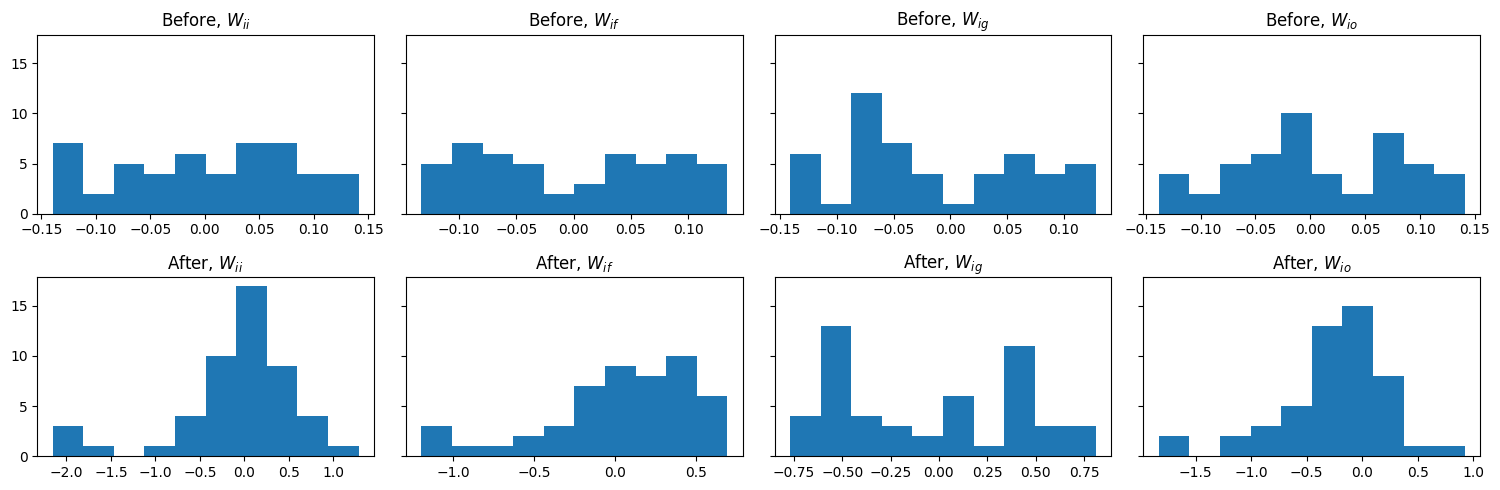

In [31]:
fig, axs = plt.subplots(2,4,sharex=False,sharey=True,figsize=(15,5))
axs[0,0].hist(weight_ih_before[0:50])
axs[0,0].set_title(r"Before, $W_{ii}$")
axs[0,1].hist(weight_ih_before[50:100])
axs[0,1].set_title(r"Before, $W_{if}$")
axs[0,2].hist(weight_ih_before[100:150])
axs[0,2].set_title(r"Before, $W_{ig}$")
axs[0,3].hist(weight_ih_before[150:200])
axs[0,3].set_title(r"Before, $W_{io}$")

axs[1,0].hist(weight_ih_after[0:50])
axs[1,0].set_title(r"After, $W_{ii}$")
axs[1,1].hist(weight_ih_after[50:100])
axs[1,1].set_title(r"After, $W_{if}$")
axs[1,2].hist(weight_ih_after[100:150])
axs[1,2].set_title(r"After, $W_{ig}$")
axs[1,3].hist(weight_ih_after[150:200])
axs[1,3].set_title(r"After, $W_{io}$")
plt.tight_layout()

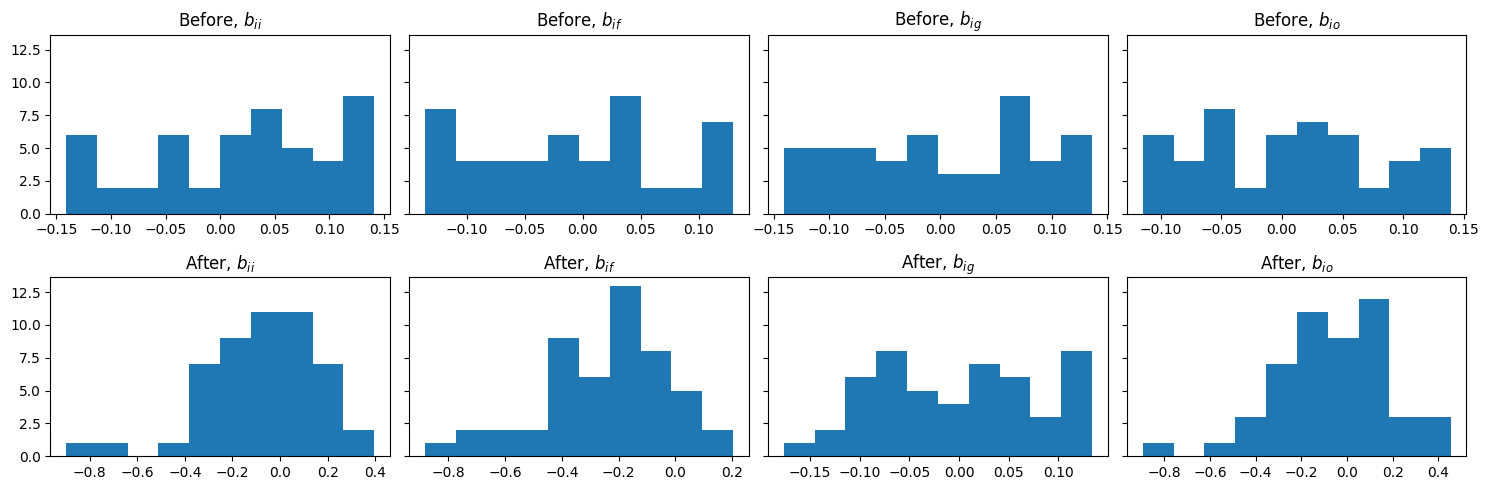

In [32]:
fig, axs = plt.subplots(2,4,sharex=False,sharey=True,figsize=(15,5))
axs[0,0].hist(bias_ih_before[0:50])
axs[0,0].set_title(r"Before, $b_{ii}$")
axs[0,1].hist(bias_ih_before[50:100])
axs[0,1].set_title(r"Before, $b_{if}$")
axs[0,2].hist(bias_ih_before[100:150])
axs[0,2].set_title(r"Before, $b_{ig}$")
axs[0,3].hist(bias_ih_before[150:200])
axs[0,3].set_title(r"Before, $b_{io}$")

axs[1,0].hist(bias_ih_after[0:50])
axs[1,0].set_title(r"After, $b_{ii}$")
axs[1,1].hist(bias_ih_after[50:100])
axs[1,1].set_title(r"After, $b_{if}$")
axs[1,2].hist(bias_ih_after[100:150])
axs[1,2].set_title(r"After, $b_{ig}$")
axs[1,3].hist(bias_ih_after[150:200])
axs[1,3].set_title(r"After, $b_{io}$")
plt.tight_layout()

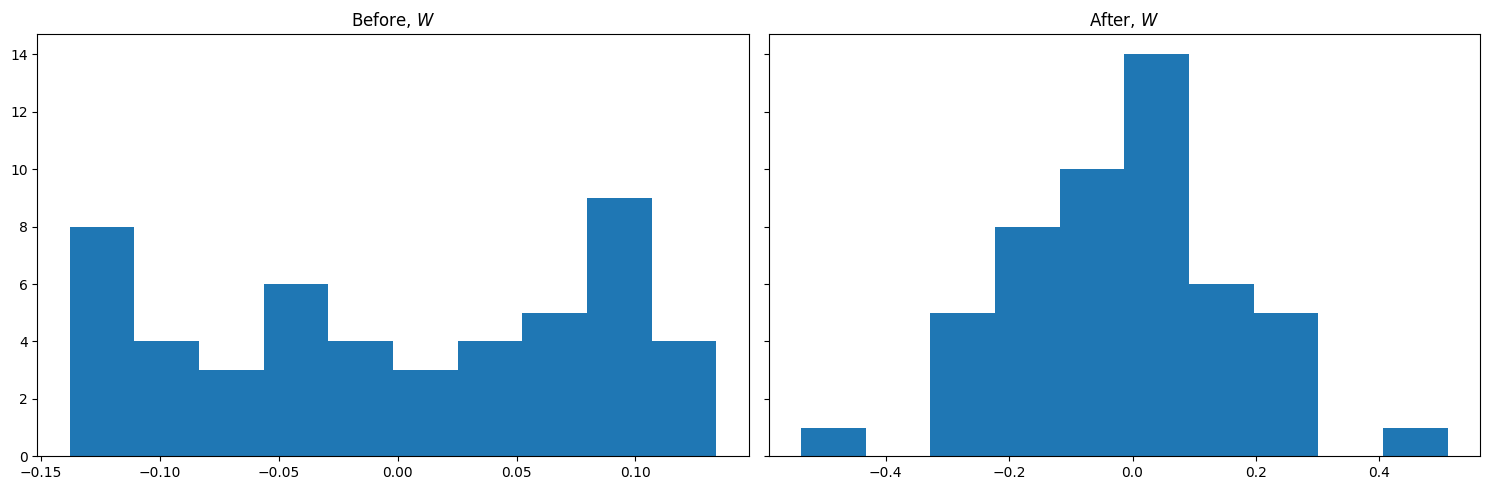

In [33]:
fig, axs = plt.subplots(1,2,sharex=False,sharey=True,figsize=(15,5))
axs[0].hist(weight_linear_before)
axs[0].set_title(r"Before, $W$")
axs[1].hist(weight_linear_after)
axs[1].set_title(r"After, $W$")
plt.tight_layout()

## Comparing the LSTM network to data

We compare the last timestep of each window through 
```
model(data)[:,-1,:]
```
to get a one dimensional array of predictions to compare to the actual measured data.

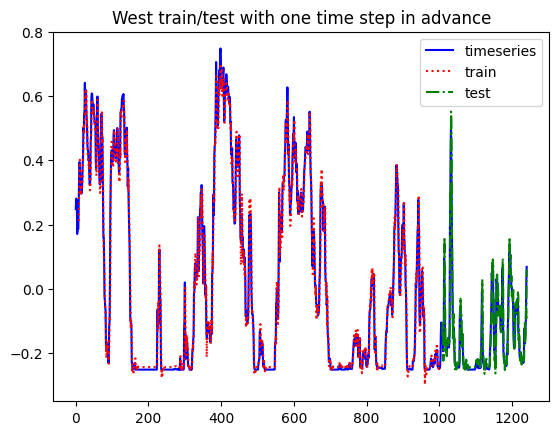

In [34]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred
    train_plot[window_size:train_size] = model(X_train)[:,-1,:]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+window_size:len(timeseries)] = model(X_test)[:,-1,:] 
# plot
plt.plot(timeseries, c='b', linestyle="-",  label="timeseries")
plt.plot(train_plot, c='r', linestyle=":",  label="train")
plt.plot(test_plot,  c='g', linestyle="-.", label="test")
plt.title("West train/test with one time step in advance")
plt.legend()
plt.show()

# How far in advance can we predict with the LSTM network?

We consider applying the network multiple times, to see if it can predict/generate output that matches the future.

In [35]:
def predict_n_advance(data, steps, model):
    output = torch.cat((data,model(data)[-1][:,None]))
    for _ in range(steps-1):
        output = torch.cat((output,model(output)[-1][:,None]))
    return output

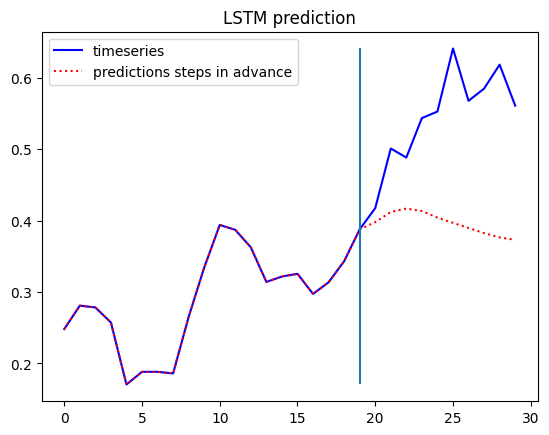

In [36]:
with torch.no_grad():
    y_pred = predict_n_advance(torch.tensor(timeseries[:20]).type(torch.float32), 10, model)
# plot
plt.plot(timeseries[:30], c='b', linestyle="-",  label="timeseries")
plt.plot(y_pred, c='r', linestyle=":",  label="predictions steps in advance")
plt.vlines(x=19,ymin=min(timeseries[:30]),ymax=max(timeseries[:30]))
plt.title("LSTM prediction")
plt.legend()
plt.show()

We see that even within the training set, applying the model multiple time steps in advance does a poor job at predicting the future. 

# Cross-validating our model on the other climate regions

The ultimate test of our models is to see if they can fit data from the other climate regions. 

In [37]:
def rmse(prediction, data):
    lf = nn.MSELoss()
    return np.sqrt(lf(prediction, data))

In [38]:
def plot_comparisons_LSTM(region_name, categories):

    fig, axs = plt.subplots(1,len(categories),sharex=False,sharey=True,figsize=(15,5))
    for (i,category) in enumerate(categories):
        timeseries, mean_std, train_set, test_set = get_region_train_test(region, category, train_size)
        y_pred = model(torch.tensor([[x] for x in timeseries]).type(torch.float32)).detach()[:,-1,:]

        axs[i].plot(timeseries, c='b', linestyle="-",  label="timeseries")
        axs[i].plot(y_pred,     c='g', linestyle="-.", label="LSTM prediction")
        axs[i].set_title(f"{category},  RMSE={rmse(y_pred,torch.tensor(timeseries)):.2f}")
    fig.legend(labels=["timeseries", "LSTM prediction"], ncol=2)
    fig.suptitle(f"LSTM network comparison, {region_name}")
    plt.tight_layout()

In [39]:
def plot_comparisons_persistence(region_name, categories):

    fig, axs = plt.subplots(1,len(categories),sharex=False,sharey=True,figsize=(15,5))
    for (i,category) in enumerate(categories):
        timeseries, mean_std, train_set, test_set = get_region_train_test(region, category, train_size)
        y_pred = persistence_model(timeseries,1)

        axs[i].plot(timeseries[1:], c='b', linestyle="-",  label="timeseries")
        axs[i].plot(y_pred,         c='g', linestyle="-.", label="persistence prediction")
        axs[i].set_title(f"{category},  RMSE={rmse(torch.tensor(y_pred),torch.tensor(timeseries[1:])):.2f}")
    fig.legend(labels=["timeseries", "persistence prediction"], ncol=2)
    fig.suptitle(f"Persistenc model comparison, {region_name}")
    plt.tight_layout()

## Midwest data

We next look at the RMSE of both the persistence and LSTM model.

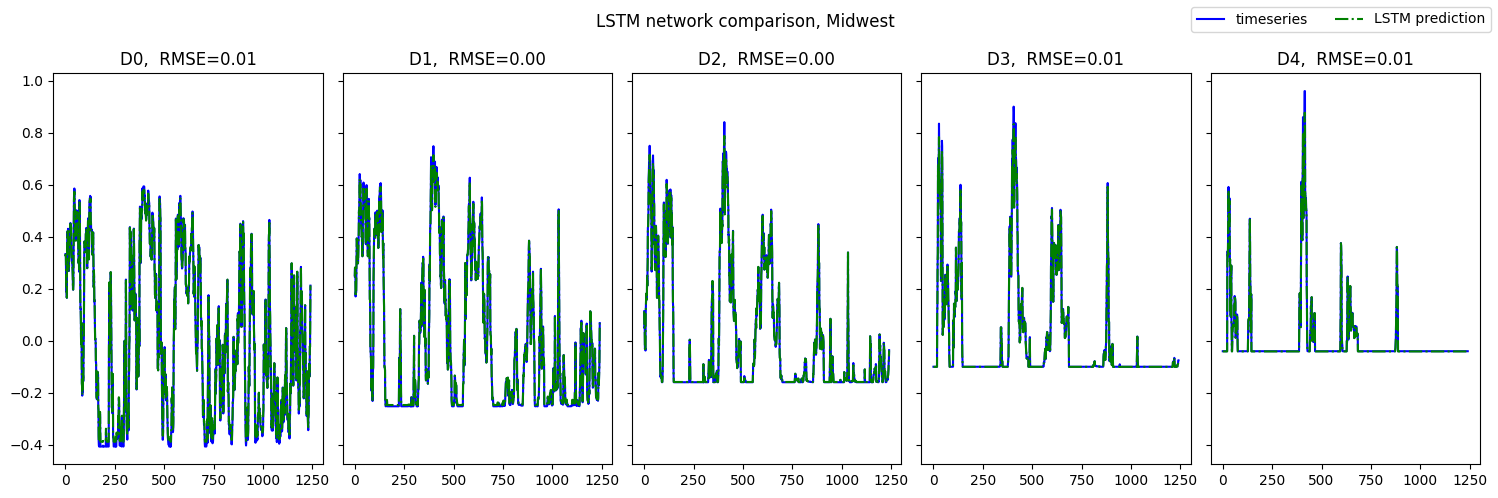

In [40]:
plot_comparisons_LSTM("Midwest", ["D0", "D1", "D2", "D3", "D4"])

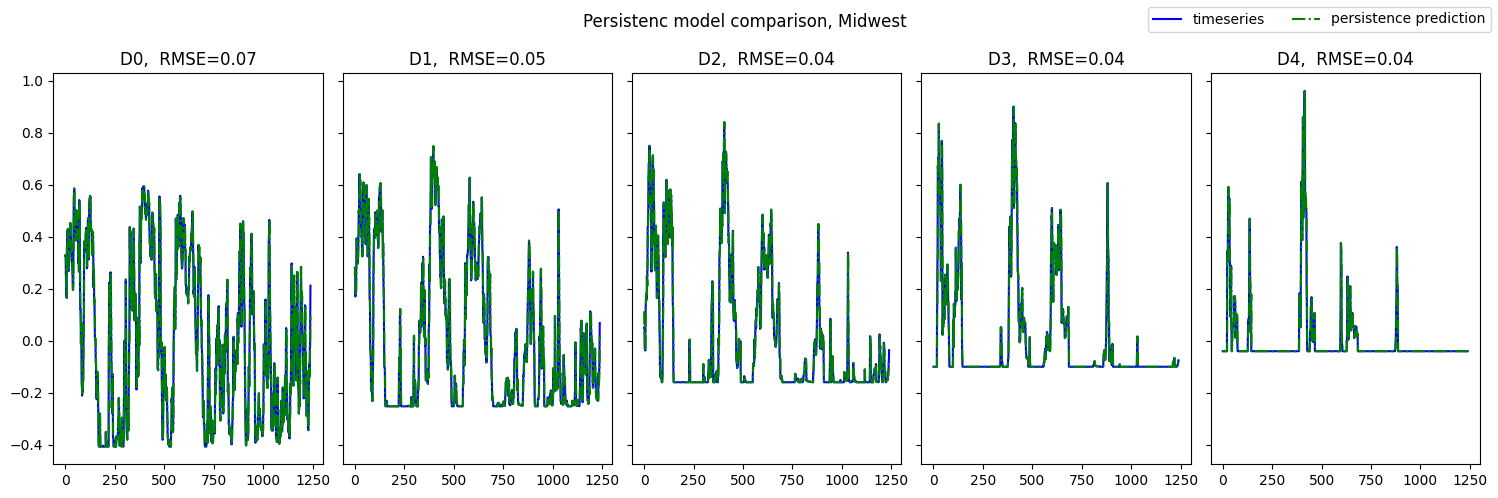

In [41]:
plot_comparisons_persistence("Midwest", ["D0", "D1", "D2", "D3", "D4"])

## South data

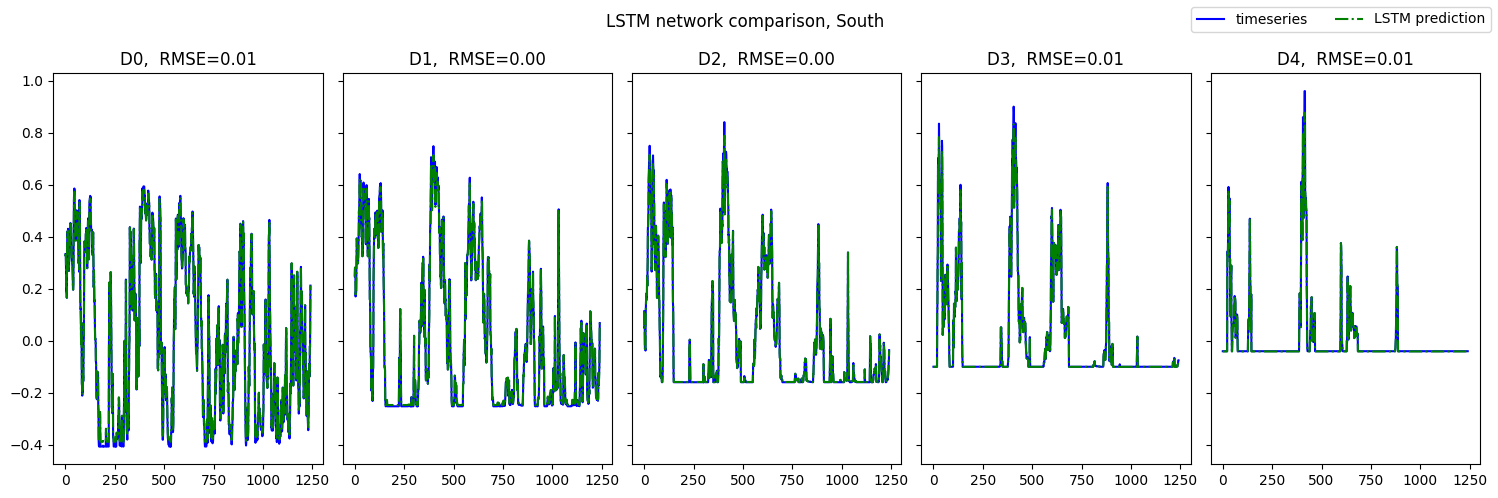

In [42]:
plot_comparisons_LSTM("South", ["D0", "D1", "D2", "D3", "D4"])

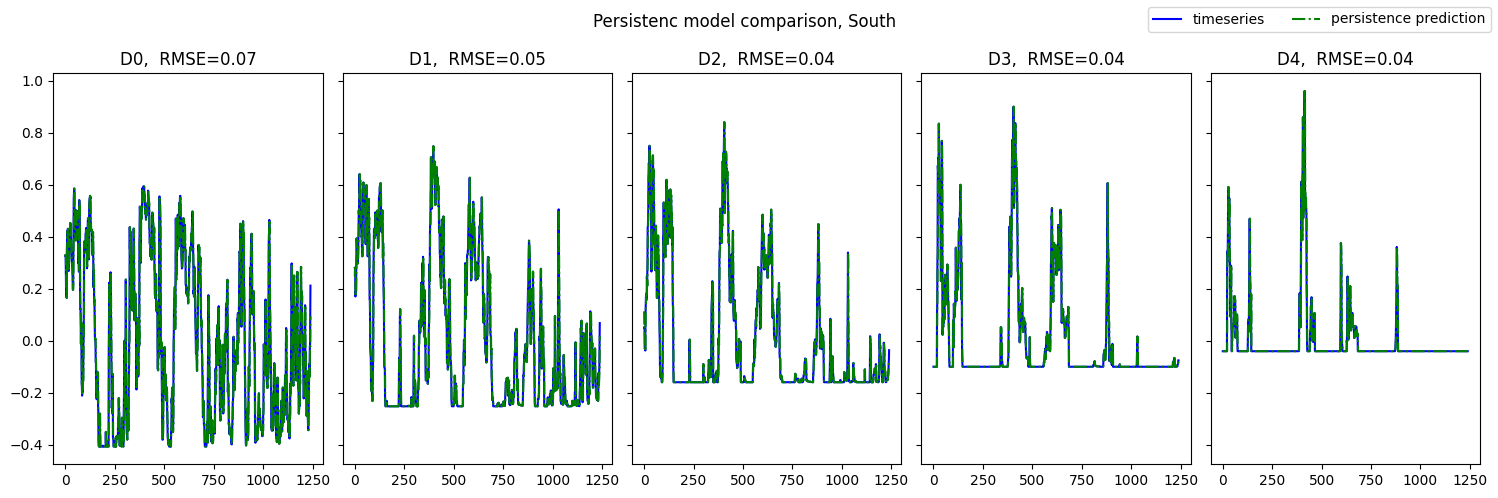

In [43]:
plot_comparisons_persistence("South", ["D0", "D1", "D2", "D3", "D4"])

## Northeast comparison

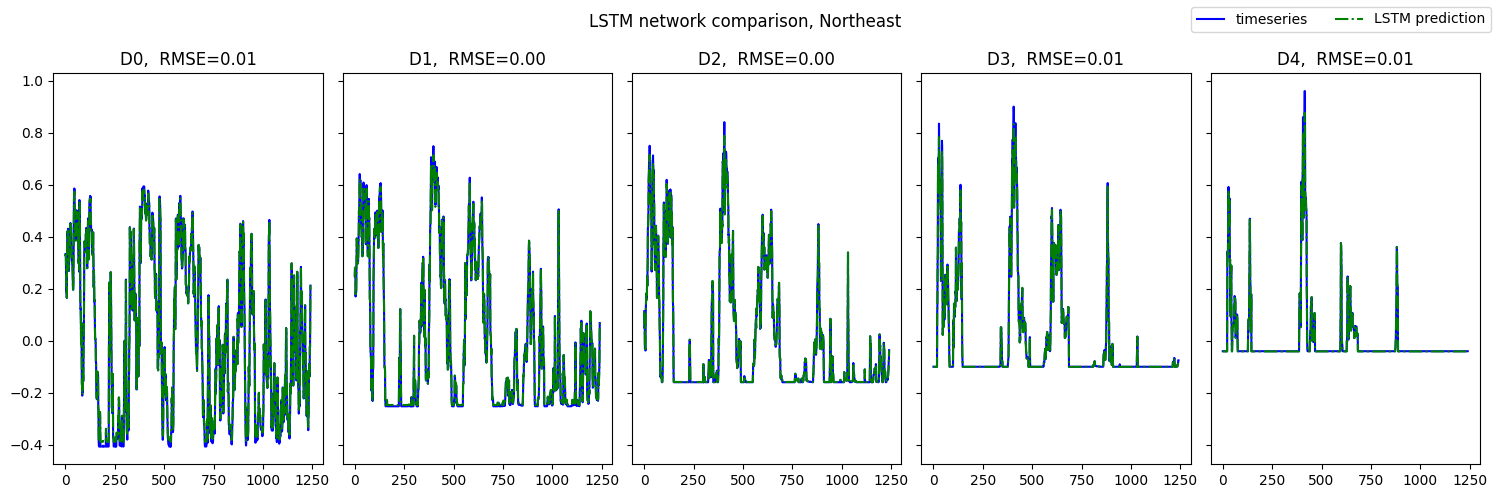

In [44]:
plot_comparisons_LSTM("Northeast", ["D0", "D1", "D2", "D3", "D4"])

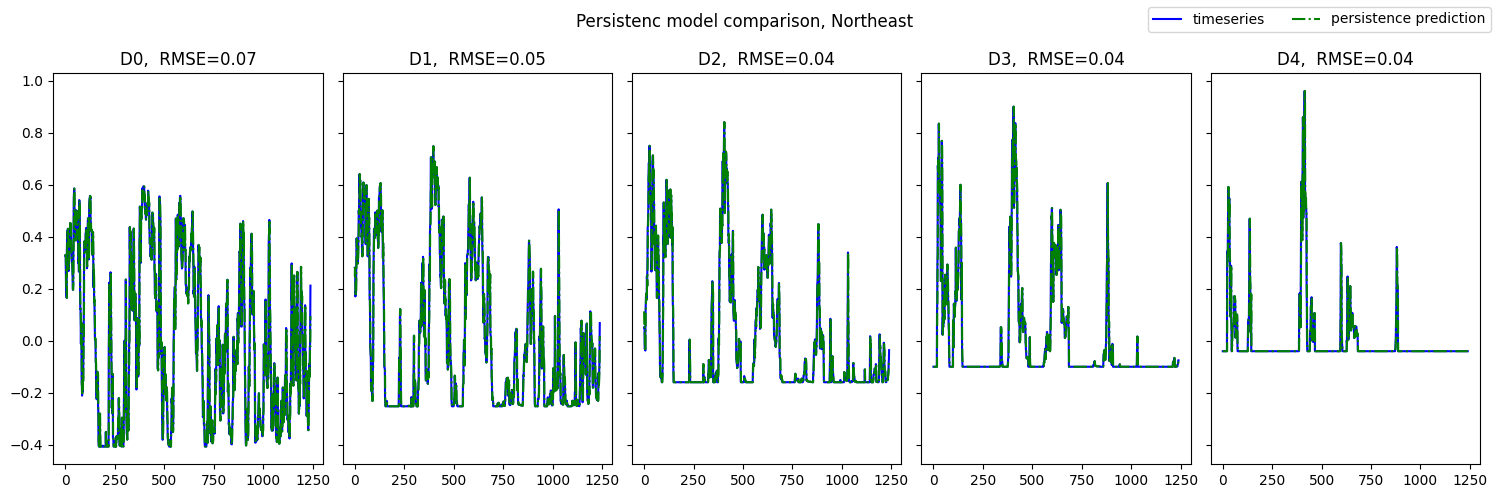

In [45]:
plot_comparisons_persistence("Northeast", ["D0", "D1", "D2", "D3", "D4"])

# Can we improve the LSTM network?

There are a few ways we could try to improve the network.

1. Train it on more data
2. Increase the hidden size
3. Increase the number of layers

Likely some combination of all three improvements will be necessary.